Aim of the project:
- To recommend content to the users based on their interactions with the OTT platform.
- This helps them get into a habit of regularly visiting the platform and engaging with the content, which in turn helps the platform to increase the user engagement, and hence the user base.
- This finally helps with user retention and user satisfaction.
- If recommendations are not possible, we need to recommend the Top 10 movies with the most ratings.

### Package installation and import

In [79]:
# %pip install numpy pandas scikit-learn matplotlib seaborn

In [80]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dataset_utils import download_and_extract_dataset_zip, datasets_dir

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### Data collection

In [81]:
dataset_foldername = 'ml-latest-small'

zip_file_path = os.path.join(datasets_dir, dataset_foldername + '.zip')
extracted_folder_path = zip_file_path.replace('.zip', '')
ratings_file = os.path.join(extracted_folder_path, 'ratings.csv')
movies_file = os.path.join(extracted_folder_path, 'movies.csv')
user_tags_file = os.path.join(extracted_folder_path, 'tags.csv')

required_files = [ratings_file, movies_file, user_tags_file]
dataset_zip_url = f'https://files.grouplens.org/datasets/movielens/{dataset_foldername}.zip'

# if the dataset files don't exist
download_and_extract_dataset_zip(dataset_zip_url, required_files)

# Load the ratings, movies, and user_tags dataframes
ratings = pd.read_csv(ratings_file)
movies = pd.read_csv(movies_file)
user_tags = pd.read_csv(user_tags_file)

print(f'Dimensions of ratings: {ratings.shape}')
ratings.head()

Dimensions of ratings: (100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [82]:
print(f'Dimensions of movies: {movies.shape}')
movies.head()

Dimensions of movies: (9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [83]:
print(f'Dimensions of user_tags: {user_tags.shape}')
user_tags.head()

Dimensions of user_tags: (3683, 4)


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


### Data Transformation

In [84]:
# Data Cleaning
# Drop any rows with missing values from the ratings, movies and user_tags dataframes
ratings.dropna(inplace=True)
movies.dropna(inplace=True)
user_tags.dropna(inplace=True)

user_tags.rename(columns={'tag': 'user_tag'}, inplace=True)

# Data Manipulation and Wrangling
# drop timestamp
ratings.drop(columns=['timestamp'], inplace=True)
user_tags.drop(columns=['timestamp'], inplace=True)

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Data Preprocessing

In [85]:
# in movies, if genre is '(no genres listed)', replace with NA
movies['genres'] = movies['genres'].apply(lambda x: x if x != '(no genres listed)' else None)

# Handle missing values
movies['genres'].fillna('', inplace=True)

# Split genres into a list in movies dataframe
if not isinstance(movies['genres'].iloc[0], list):
    movies['genres'] = movies['genres'].str.split('|')

# Merge the dataframes on 'movieId' to create a single dataframe
merged_df = pd.merge(ratings, movies, on='movieId')
merged_df.drop(columns=['title'], inplace=True)  # drop movie title
merged_df = pd.merge(merged_df, user_tags, on=['movieId', 'userId'], how='left')

if merged_df.isnull().sum().any():
    columns_with_missing_values = merged_df.columns[merged_df.isnull().any()].tolist()
    columns_with_missing_values = ', '.join(columns_with_missing_values)
    print(f'There are missing values in columns: {columns_with_missing_values}')

# Normalize the data
merged_df['rating'] = (merged_df['rating'] - merged_df['rating'].min()) / (merged_df['rating'].max() - merged_df['rating'].min())

merged_df.head()

There are missing values in columns: user_tag


,userId,movieId,rating,genres,user_tag
0,1,1,0.777778,"[Adventure, Animation, Children, Comedy, Fantasy]",NaN
1,5,1,0.777778,"[Adventure, Animation, Children, Comedy, Fantasy]",NaN
2,7,1,0.888889,"[Adventure, Animation, Children, Comedy, Fantasy]",NaN
3,15,1,0.444444,"[Adventure, Animation, Children, Comedy, Fantasy]",NaN
4,17,1,0.888889,"[Adventure, Animation, Children, Comedy, Fantasy]",NaN


In [86]:
# display where merged_ratings_df is not null
merged_df[merged_df['user_tag'].notnull()].head()

,userId,movieId,rating,genres,user_tag
121,336,1,0.777778,"[Adventure, Animation, Children, Comedy, Fantasy]",pixar
164,474,1,0.777778,"[Adventure, Animation, Children, Comedy, Fantasy]",pixar
193,567,1,0.666667,"[Adventure, Animation, Children, Comedy, Fantasy]",fun
241,289,3,0.444444,"[Comedy, Romance]",moldy
242,289,3,0.444444,"[Comedy, Romance]",old


In [87]:
# Calculate the average rating of each movie
movies['average_rating'] = ratings.groupby('movieId')['rating'].mean()
# Calculate the number of ratings of each movie
movies['number_of_ratings'] = ratings.groupby('movieId')['rating'].count()

movies = movies.set_index('movieId')

movies.head()

,title,genres,average_rating,number_of_ratings
movieId,,,,
1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",NaN,NaN
2,Jumanji (1995),"[Adventure, Children, Fantasy]",3.920930,215.0
3,Grumpier Old Men (1995),"[Comedy, Romance]",3.431818,110.0
4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",3.259615,52.0
5,Father of the Bride Part II (1995),[Comedy],2.357143,7.0


### Data Exploration

#### EDA

In [88]:
print('Ratings Dataframe Info:')
print(ratings.info())
print('\nMovies Dataframe Info:')
print(movies.info())
print('\nUser Tags Dataframe Info:')
print(user_tags.info())

Ratings Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 3.1 MB
None

Movies Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9742 entries, 1 to 193609
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              9742 non-null   object 
 1   genres             9742 non-null   object 
 2   average_rating     5390 non-null   float64
 3   number_of_ratings  5390 non-null   float64
dtypes: float64(2), object(2)
memory usage: 380.5+ KB
None

User Tags Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3683 entries, 0 to 3682
Data columns (total 3 columns):
 #  

#### Data Visualization

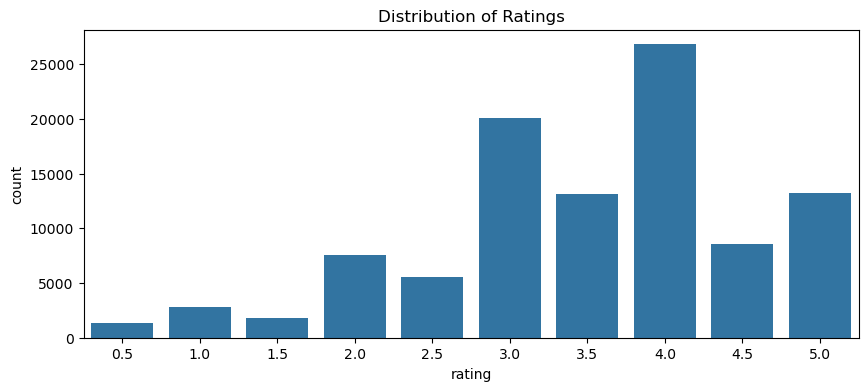

In [89]:
# Distribution of ratings
plt.figure(figsize=(10, 4))
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Ratings')
plt.show()

#### Top 10 movies with the most ratings

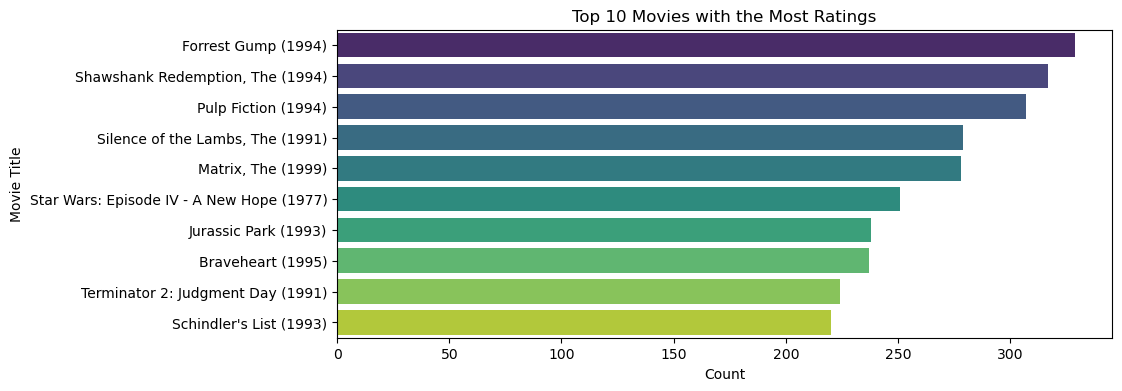

In [90]:
top_movies = ratings['movieId'].value_counts()[:10]
top_movies = pd.DataFrame({'movieId': top_movies.index, 'count': top_movies.values})
top_movies = pd.merge(top_movies, movies, on='movieId')

plt.figure(figsize=(10, 4))
sns.barplot(x='count', y='title', hue='title', data=top_movies, palette='viridis')
plt.title('Top 10 Movies with the Most Ratings')
plt.xlabel('Count')
plt.ylabel('Movie Title')
plt.show()

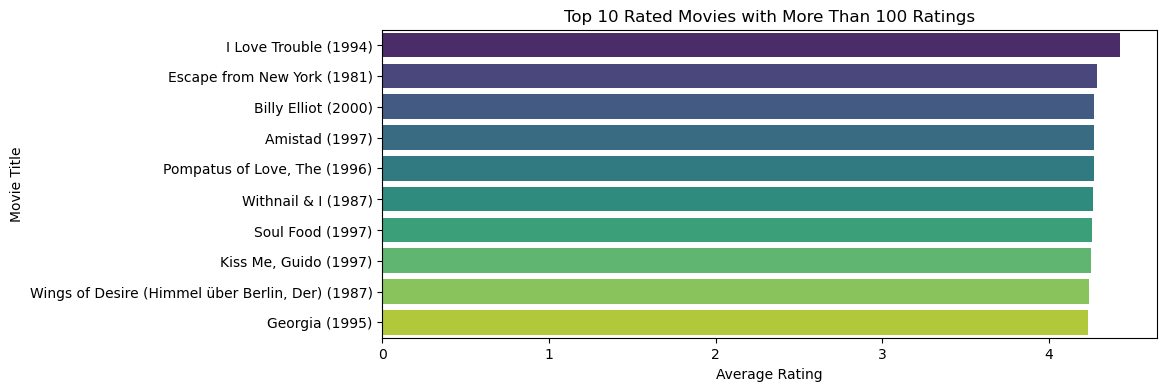

In [91]:
# Consider movies with more than specific ratings
movies_to_consider = movies[movies['number_of_ratings'] >= 50]
top_rated_movies = movies_to_consider.sort_values('average_rating', ascending=False)[:10]

# Plot the top 10 rated movies
plt.figure(figsize=(10, 4))
sns.barplot(x='average_rating', y='title', hue='title', data=top_rated_movies, palette='viridis')
plt.title('Top 10 Rated Movies with More Than 100 Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.show()

### Feature Engineering

#### Feature Selection

#### Feature Extraction

#### Feature Scaling

#### Visualization of the selected features with pair plots

#### Correlation Matrix